Step 1: Import all we need

Need to use sklearn to evaluate the predictive model, so please install the sklearn library :
pip install scikit-learn



In [28]:
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

Step 2: Data Preparation and Feature Engineering

In [29]:

# Load spaCy and add TextBlob component
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

# Define a function to classify sentiment using SpaCyTextBlob
def classify_sentiment(text):
    doc = nlp(text)
     # get the sentiment score
    sentiment_score = doc._.blob.polarity
    return sentiment_score

# Clean text function
def clean_text(text):
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Load and prepare data
df = pd.read_csv('testin.csv')
df['body'] = df['body'].apply(clean_text)
df['sentiment_score'] = df['body'].apply(classify_sentiment)

# Feature Engineering
df['message_length'] = df['body'].apply(len)
df['word_count'] = df['body'].apply(lambda x: len(str(x).split()))
df['exclamation_count'] = df['body'].str.count(r'!')
df['question_count'] = df['body'].str.count(r'\?')
df['capital_words'] = df['body'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', str(x))))  # could be shouting 
df['has_positive_subject'] = df['Subject'].str.contains('thank|congrat|happy', case=False).astype(int)
df['has_negative_subject'] = df['Subject'].str.contains('urgent|issue|problem', case=False).astype(int)


# Convert date to datetime and extract temporal features
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['hour_sent'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
df['month'] = df['date'].dt.month


# Calculate message frequency by sender
sender_counts = df['from'].value_counts().to_dict()
df['sender_frequency'] = df['from'].map(sender_counts)

# Formality (salutations like "Dear" or "Regards")
df['has_salutation'] = df['body'].str.contains('dear|regards|sincerely', case=False).astype(int)



Step 3: Select Features and Split Data

In [30]:
# Select features for modeling
features = [
    'message_length', 'word_count', 'exclamation_count', 
    'question_count', 'capital_words', 'has_positive_subject',
    'has_negative_subject', 'hour_sent', 'day_of_week', 
    'is_weekend', 'month', 'sender_frequency','has_salutation'
]

X = df[features]
y = df['sentiment_score']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Step 4: Train Linear Regression Model

In [31]:
# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

Step 5: Evaluate and Interpret Model Performance

In [32]:
# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Evaluation Metrics:")
print(f"R-squared: {r2:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"Root Mean Squared Error: {rmse:.3f}")


Model Evaluation Metrics:
R-squared: 0.101
Mean Absolute Error: 0.154
Root Mean Squared Error: 0.213


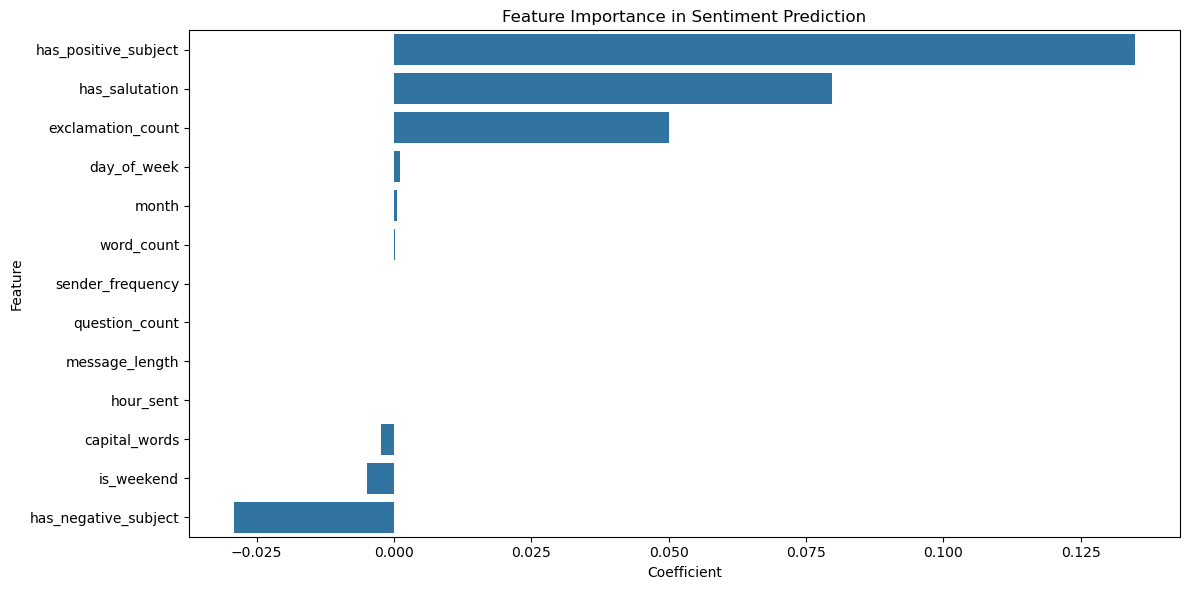

In [34]:
# Get feature coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values('Coefficient', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Feature Importance in Sentiment Prediction')
plt.tight_layout()
#plt.savefig('Feature Importance in Sentiment Prediction')
plt.show()